In [1]:
from matplotlib.colors import LinearSegmentedColormap
from data_utils import load_installed_capacity
from forecast_engine import DataLoader
from aquarel import load_theme  # lightweight templating engine and wrapper around Matplotlibs' rcparams
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

In [2]:
import getpass
export_username = "ts" # Only save plots to dropbox on my machine
def save_plot(plot, filename):
    username = getpass.getuser()
    filepath = "/Users/ts/Library/CloudStorage/Dropbox/Apps/Overleaf/Dissertation Oxford/Figures"
    filename += ".pdf"
    if username == export_username:
        plot.savefig(os.path.join(filepath, filename), format='pdf') 

In [3]:
# Load Merged data
data_loader = DataLoader("data/merged")
data_loader.load_data()
load_forecast = data_loader.data['load_forecast']
wind_solar_forecast = data_loader.data['wind_solar_forecast']
day_ahead_prices = data_loader.data['day_ahead_prices']
coal_gas = data_loader.data['coal_gas']
generation_forecast = data_loader.data['generation_forecast']

# Prepare the data
countries = day_ahead_prices.columns
n_countries = len(countries)

Using installed capacity data from 2019


In [4]:
# Custom color palette
col_pal = [
    '#FF3B30',  # Red
    '#FF9500',  # Orange
    '#FFCC00',  # Yellow
    '#34C759',  # Green
    '#00C7BE',  # Mint
    '#30B0C7',  # Teal
    '#32ADE6',  # Cyan
    '#007AFF',  # Blue
    '#5856D6',  # Indigo
    '#AF52DE',  # Purple
    '#FF6483',  # Pink
    '#A2845E'   # Brown
]
# Set up the plot theme
theme = (
    load_theme("boxy_light")
    .set_overrides({
        'axes.prop_cycle': plt.cycler(color=col_pal),
        'text.usetex': True,
        'font.family': 'serif',
        'font.serif': ['Computer Modern']
    })
)
theme.apply()

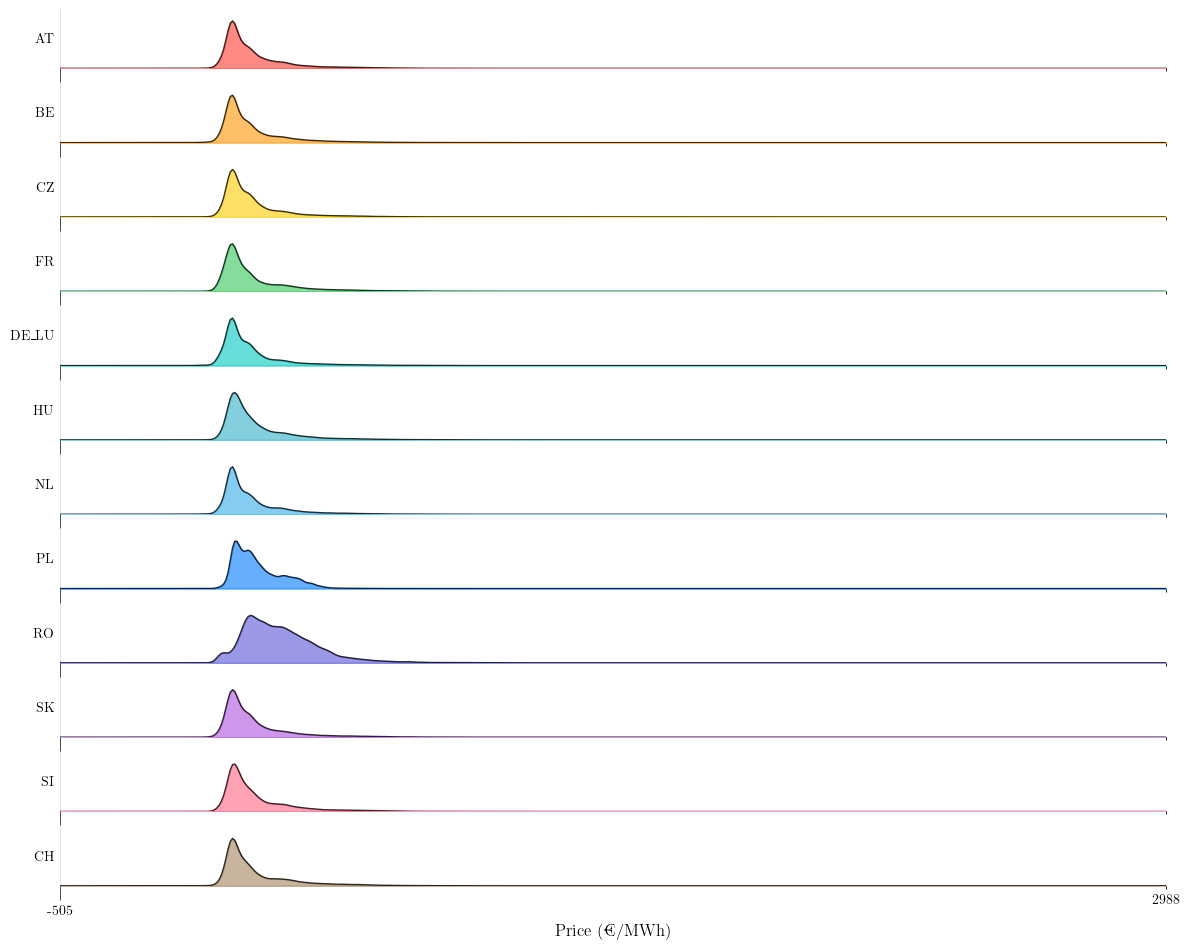

In [5]:
# Set up the plot
fig, axes = plt.subplots(n_countries, 1, figsize=(12, 0.8*n_countries), sharex=True)
fig.subplots_adjust(hspace=0)  # Remove vertical space between subplots

# Set x-axis range
x_min, x_max = (day_ahead_prices.min().min() - 5), day_ahead_prices.max().max()

for i, (country, ax) in enumerate(zip(countries, axes)):
    data = day_ahead_prices[country].dropna()
    density = gaussian_kde(data)  # Calculate kernel density estimation
    xs = np.linspace(x_min, x_max, 500)
    ys = density(xs)
    ys = 0.8 * ys / ys.max()  # Normalize ys to max of 0.8 to leave space for labels
    ax.fill_between(xs, ys, alpha=0.6, color=col_pal[i % len(col_pal)])  # Plot the KDE
    ax.plot(xs, ys, color='black', alpha=0.8, linewidth=1)
    ax.set_ylabel(country, rotation=0, ha='right', va='center') # Set country name as y-axis label
    ax.set_yticks([]) # Remove y-axis ticks
    ax.set_ylim(0, 1)  # Set y-limit to 1 for all subplots
    ax.set_xticks([0])  # Add a tick and label at 0 on the x-axis
    ax.set_xticklabels(['0'])
    # add tick at x_min
    ax.set_xticks([x_min])
    ax.set_xticklabels([f'{x_min:.0f}'])
    # add tick at x_max
    ax.set_xticks([x_max], minor=True)
    ax.set_xticklabels([f'{x_max:.0f}'], minor=True)
    for spine in ax.spines.values():
        spine.set_visible(False)  # Remove the box around the subplot

# Set overall title and x-axis label
# fig.suptitle('Distribution of Day-Ahead Electricity Prices by Country', fontsize=16)
axes[-1].set_xlabel('Price (€/MWh)', fontsize=12)
plt.xlim(x_min, x_max)  # Set x-axis limits
plt.tight_layout()
theme.apply_transforms()

plt.show()
save_plot(fig, "day_ahead_prices_distribution")

In [6]:
day_ahead_prices.columns

Index(['AT', 'BE', 'CZ', 'FR', 'DE_LU', 'HU', 'NL', 'PL', 'RO', 'SK', 'SI',
       'CH'],
      dtype='object')

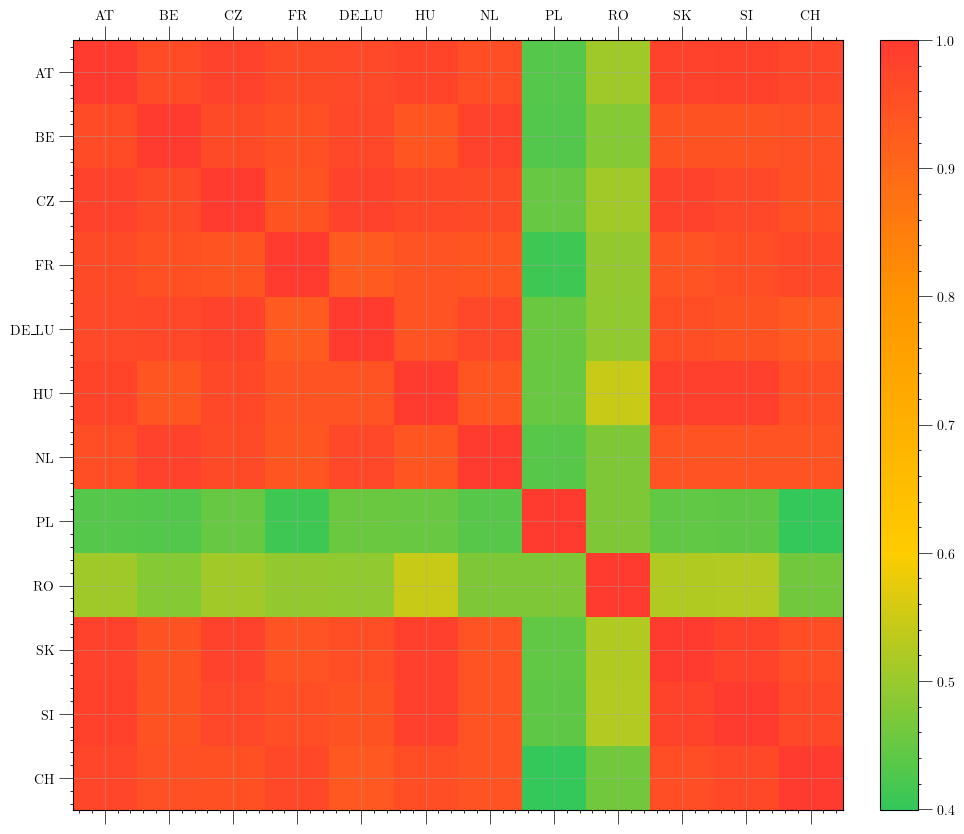

In [7]:
# make a correlation heatmap of day-ahead prices
cmap = LinearSegmentedColormap.from_list("custom_blue", ['#34C759', '#FFCC00', '#FF9500', '#FF3B30'])
corr = day_ahead_prices.corr()
corrfig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(corr, cmap=cmap)

# Ensure all countries are shown on the axis ticks
ax.set_xticks(range(len(countries)))
ax.set_xticklabels(countries)  # No rotation for x-axis labels
ax.set_yticks(range(len(countries)))
ax.set_yticklabels(countries)

# Add a colorbar
cbar = plt.colorbar(cax, fraction=0.046, pad=0.04)
plt.show()
save_plot(corrfig, "day_ahead_prices_correlation")

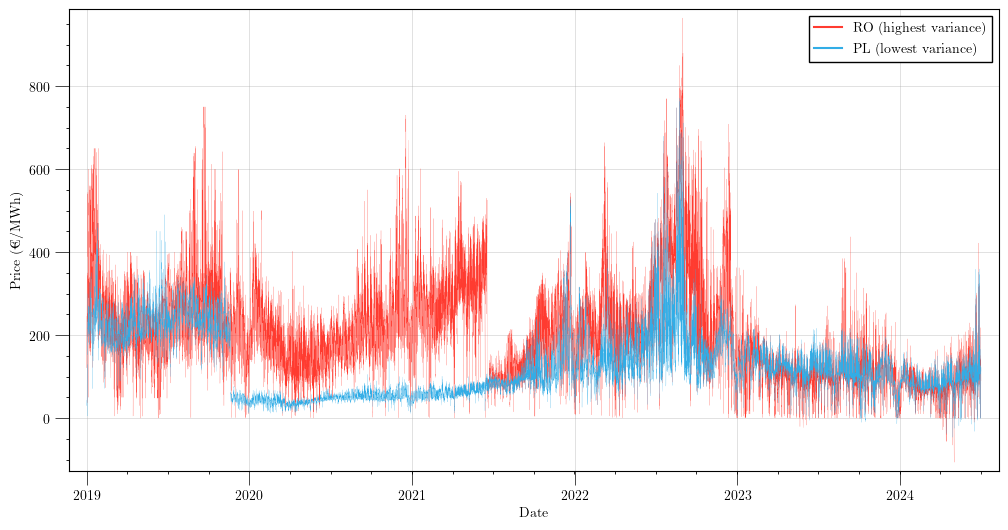

In [8]:
from matplotlib.lines import Line2D

colors = [col_pal[0], col_pal[6]]

# Define custom labels
custom_labels = [" (highest variance)", " (lowest variance)"]

variance = day_ahead_prices.var()
highvar_country = variance.idxmax()
lowvar_country = variance.idxmin()
countries = [highvar_country, lowvar_country]
varplot = plt.figure(figsize=(12, 6))

for i, country in enumerate(countries):
    plt.plot(day_ahead_prices.index, day_ahead_prices[country], label=country + custom_labels[i], linewidth=0.1, color=colors[i])

# Create custom legend handles with default linewidth and custom labels
legend_handles = [Line2D([0], [0], color=colors[i], label=country + custom_labels[i]) for i, country in enumerate(countries)]

# plt.title('Day-Ahead Electricity Prices for Selected Countries')
plt.xlabel('Date')
plt.ylabel('Price (€/MWh)')
plt.legend(handles=legend_handles)
theme.apply_transforms()
plt.show()
save_plot(varplot, "day_ahead_prices_variance")

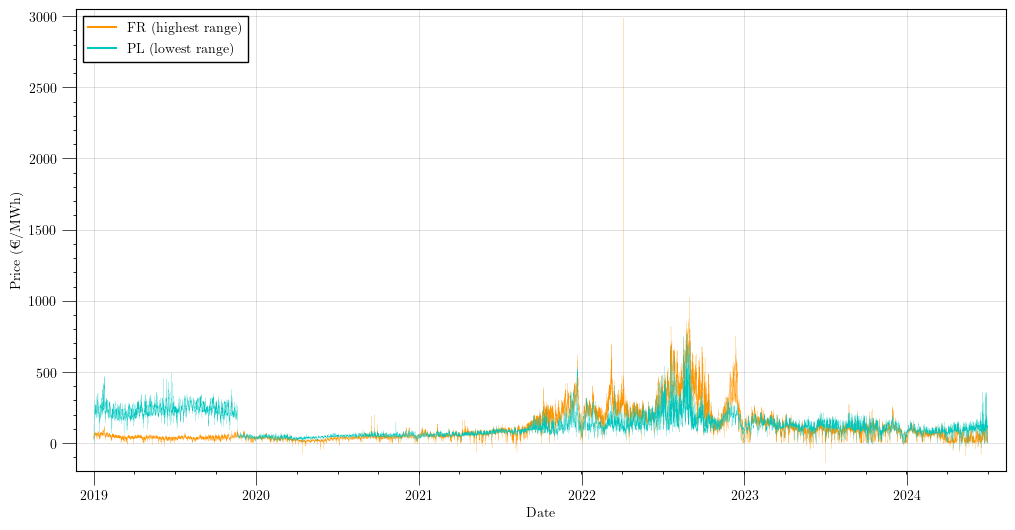

In [9]:
from matplotlib.lines import Line2D

# Define the colors
colors = [col_pal[1], col_pal[4]]

# Define custom labels
custom_labels = [" (highest range)", " (lowest range)"]

# Calculate the range for each country
ranges = day_ahead_prices.max() - day_ahead_prices.min()
highrange_country = ranges.idxmax()
lowrange_country = ranges.idxmin()
countries = [highrange_country, lowrange_country]
rangeplot = plt.figure(figsize=(12, 6))

for i, country in enumerate(countries):
    plt.plot(day_ahead_prices.index, day_ahead_prices[country], label=country + custom_labels[i], linewidth=0.1, color=colors[i])

# Create custom legend handles with default linewidth and custom labels
legend_handles = [Line2D([0], [0], color=colors[i], label=country + custom_labels[i]) for i, country in enumerate(countries)]

# plt.title('Day-Ahead Electricity Prices for Selected Countries')
plt.xlabel('Date')
plt.ylabel('Price (€/MWh)')
plt.legend(handles=legend_handles, loc='upper left')
theme.apply_transforms()
plt.show()
save_plot(rangeplot, "day_ahead_prices_range")

In [10]:
def plot_combined_missingness(title):
    """
    Plots the missingness of data for each country over time for three different datasets.

    Parameters:
    load_forecast (pd.DataFrame): DataFrame containing the load forecast data.
    generation_forecast (pd.DataFrame): DataFrame containing the generation forecast data.
    wind_solar_forecast (pd.DataFrame): DataFrame containing the wind and solar forecast data.
    title (str): Title of the plot.

    Returns:
    matplotlib.figure.Figure: The figure object containing the plot.
    """
    load_forecast = data_loader.data['load_forecast']
    generation_forecast = data_loader.data['generation_forecast']
    wind_solar_forecast = data_loader.data['wind_solar_forecast']
    countries = load_forecast.columns
    dates = load_forecast.index

    fig, ax = plt.subplots(figsize=(15, 10))

    for i, country in enumerate(countries):
        load_missing = load_forecast[country].isna()
        gen_missing = generation_forecast[country].isna()
        wind_solar_missing = wind_solar_forecast[country].isna()
        
        # Plot non-missing data
        ax.scatter(dates[~load_missing], [i] * (~load_missing).sum(), color='#e5e5ea', 
                   s=1, marker='|', linewidths=0.5)
        
        # Plot missing data for load forecast
        ax.scatter(dates[load_missing], [i - 0.2] * load_missing.sum(), color='#FF3B30', 
                   s=10, marker='|', linewidths=1, label='Load Forecast' if i == 0 else "")
        
        # Plot missing data for generation forecast
        ax.scatter(dates[gen_missing], [i + 0] * gen_missing.sum(), color='#00C7BE', 
                   s=10, marker='|', linewidths=1, label='Generation Forecast' if i == 0 else "")
        
        # Plot missing data for wind and solar forecast
        ax.scatter(dates[wind_solar_missing], [i + 0.2] * wind_solar_missing.sum(), color='#AF52DE', 
                   s=10, marker='|', linewidths=1, label='Wind and Solar Forecast' if i == 0 else "")

    ax.set_yticks(range(len(countries)))
    ax.set_yticklabels(countries)
    ax.set_xlabel('Date')
    ax.set_title(title)

    # Improve x-axis labeling
    ax.xaxis_date()
    fig.autofmt_xdate()  # Rotate and align the tick labels

    # Add legend with larger markers
    legend = ax.legend(loc='upper left', markerscale=2)
    for handle in legend.legend_handles:
        handle.set_linewidth(20)

    plt.tight_layout()
    return fig

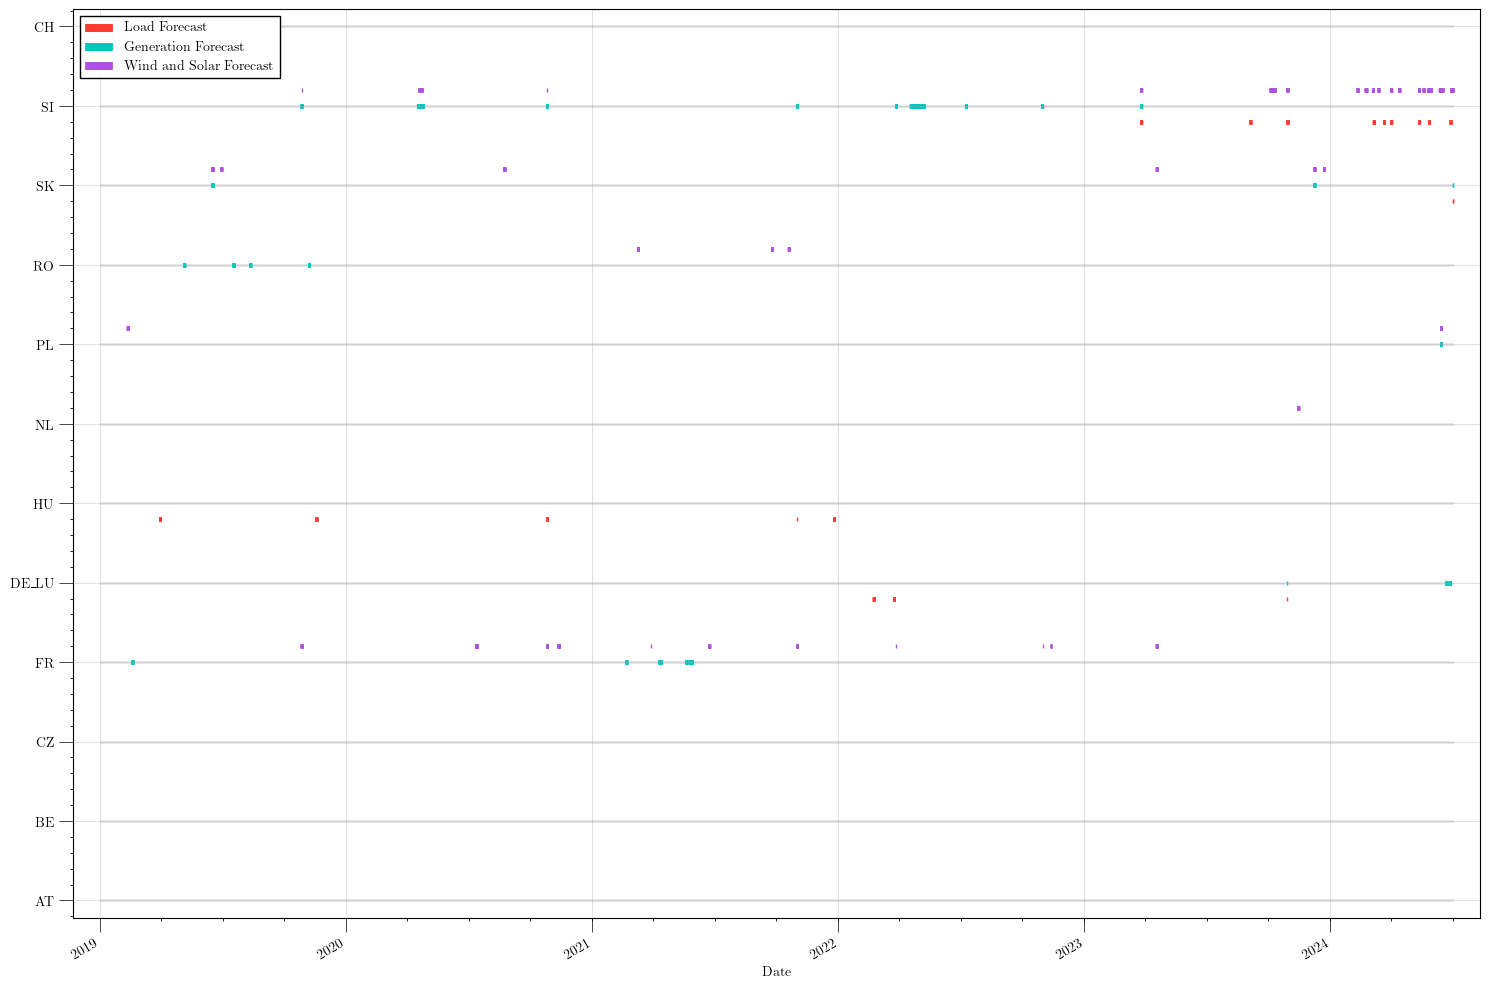

In [11]:
fig_combined = plot_combined_missingness('')
save_plot(fig_combined, "missingness_combined")

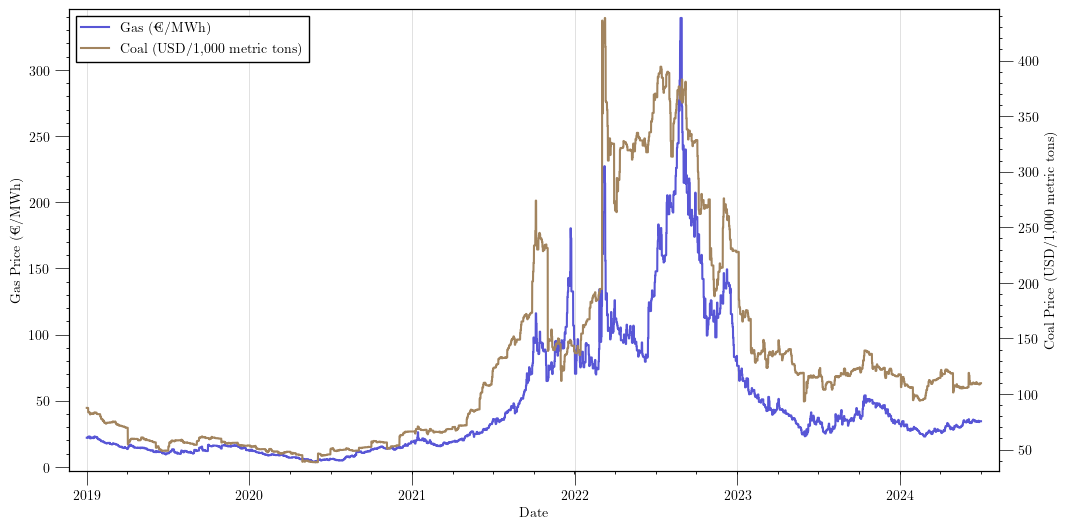

In [12]:
# Make plot of coal and gas values with dual y-axes
cgfig, ax1 = plt.subplots(figsize=(12, 6))

# Plot gas prices on the left y-axis
ax1.plot(coal_gas.index, coal_gas['gas'], color='#5856D6', label='Gas (€/MWh)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Gas Price (€/MWh)')
ax1.tick_params(axis='y')
ax1.grid(False, axis='y')  # Turn off horizontal gridlines
# ax1.legend(loc='upper left')

# Create a second y-axis for coal prices
ax2 = ax1.twinx()
ax2.plot(coal_gas.index, coal_gas['coal'], color='#A2845E', label='Coal (USD/1,000 metric tons)')
ax2.set_ylabel('Coal Price (USD/1,000 metric tons)')
ax2.tick_params(axis='y')
ax2.grid(False, axis='y')  # Turn off horizontal gridlines
# ax2.legend(loc='upper right')
cgfig.legend(loc='upper left', bbox_to_anchor=(0, 1), bbox_transform=ax1.transAxes)
theme.apply_transforms()
# Show the plot
plt.show()
save_plot(cgfig, "coal_gas_prices")

In [13]:
# load installed capacity data for 2019-2023
ic19 = load_installed_capacity('2019')
ic20 = load_installed_capacity('2020')
ic21 = load_installed_capacity('2021')
ic22 = load_installed_capacity('2022')
ic23 = load_installed_capacity('2023')
ic24 = load_installed_capacity('2024')
ic = pd.concat([ic19, ic20, ic21, ic22, ic23, ic24], axis=1)  # combine individual dataframes into one
# rename all columns to the year
ic.columns = range(2019, 2025)

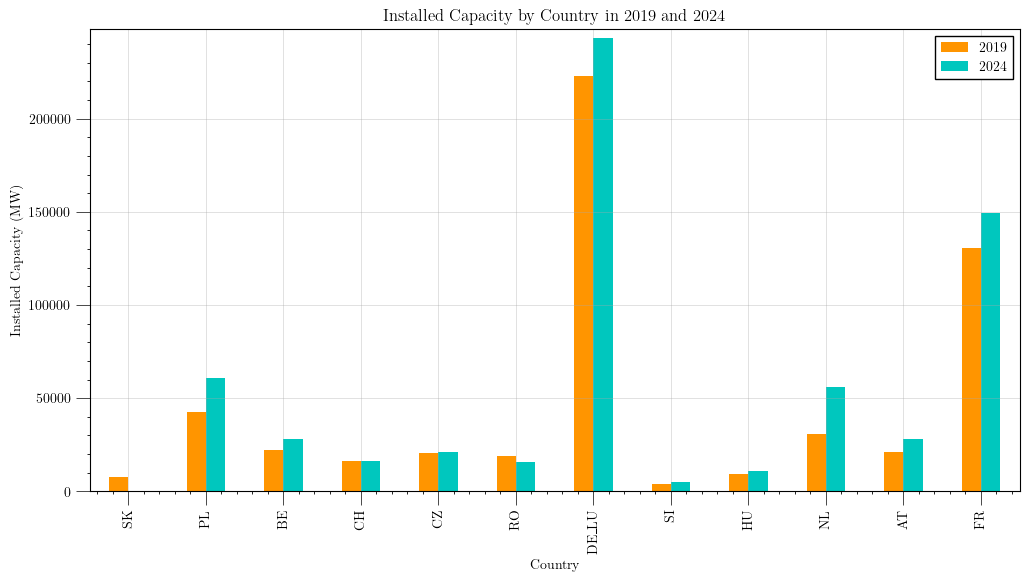

In [14]:
# make plot of installed capacity for each country in 2019 and 2024
icfig, ax = plt.subplots(figsize=(12, 6))
ic.loc[:, [2019, 2024]].plot(kind='bar', ax=ax, color=[col_pal[1], col_pal[4]])
ax.set_xlabel('Country')
ax.set_ylabel('Installed Capacity (MW)')
ax.set_title('Installed Capacity by Country in 2019 and 2024')
theme.apply_transforms()
plt.show()
save_plot(icfig, "installed_capacity_absolute")

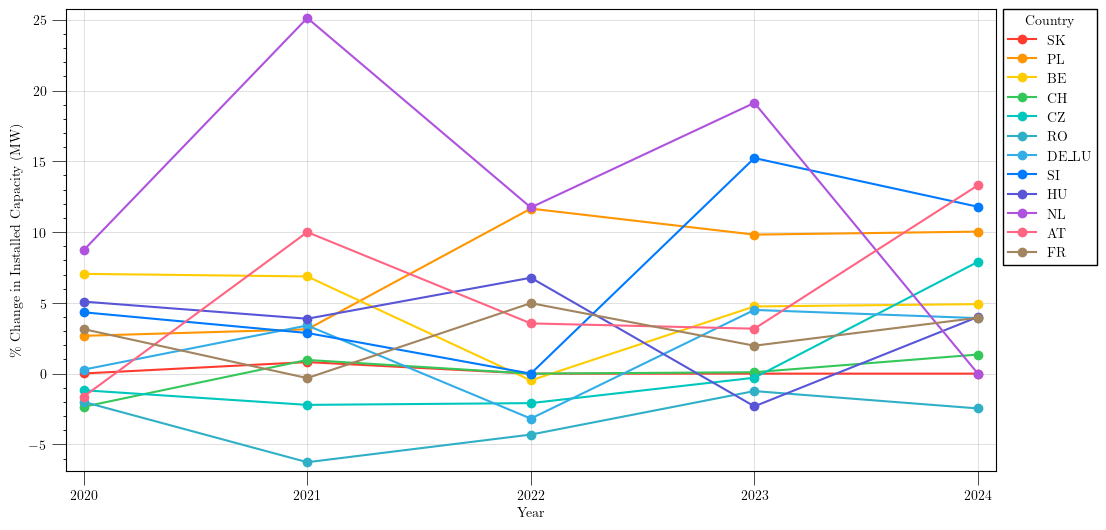

In [15]:
# Calculate the percentage change in installed capacity for each country for each year
ic_pct_change = ic.pct_change(axis=1) * 100

# Create a plot
icfig2, ax = plt.subplots(figsize=(12, 6))

# Plot the percentage changes for each country
for country in ic_pct_change.index:
    ax.plot(ic_pct_change.columns, ic_pct_change.loc[country], marker='o', label=country)

# Customize the plot
ax.set_xlabel('Year')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_ylabel('\\% Change in Installed Capacity (MW)')
ax.legend(title='Country', bbox_to_anchor=(1, 1.015), loc='upper left')
# icfig2.legend(title='Country', loc='upper right', ncol=2)
theme.apply_transforms()

# Show the plot
plt.show()
save_plot(icfig2, "installed_capacity_percentage_change")

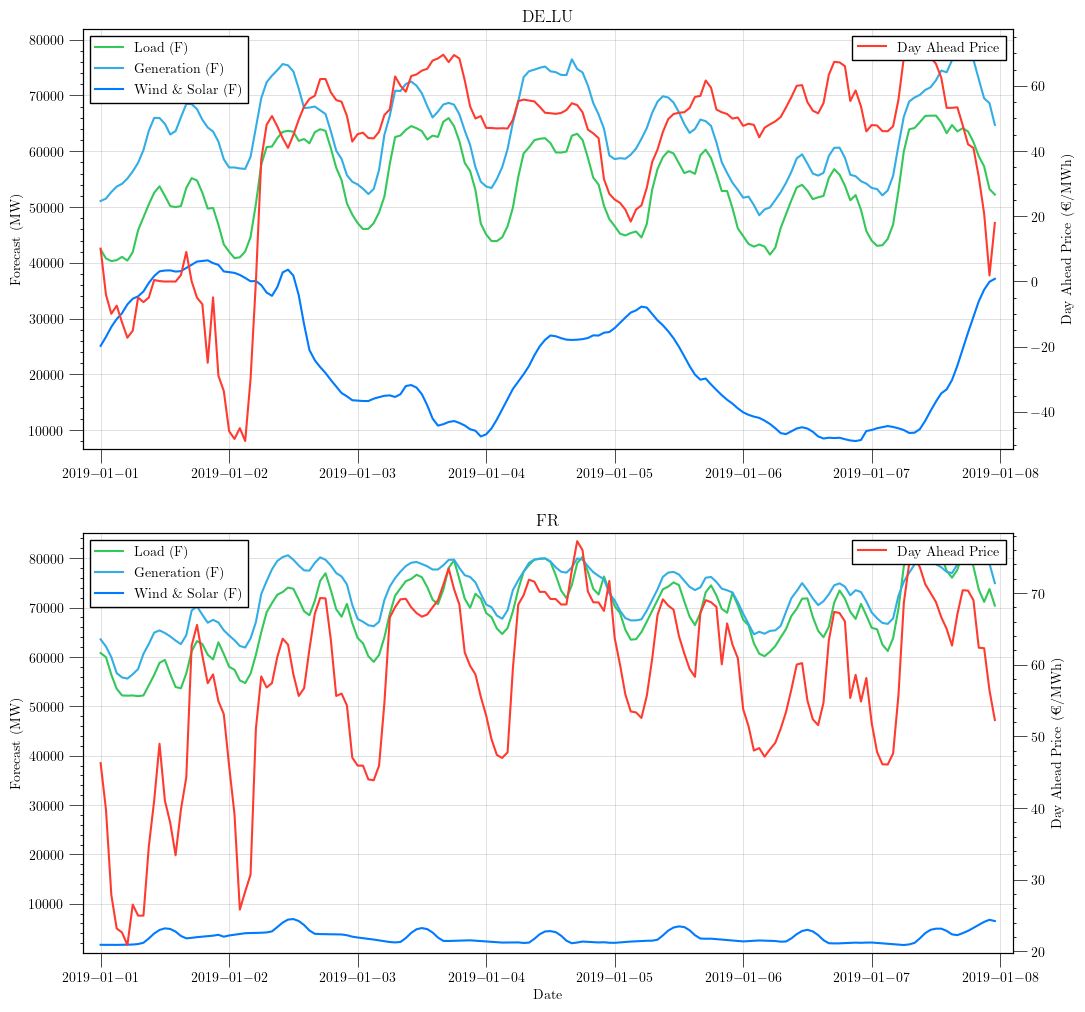

In [16]:
# Select countries
country1 = 'DE_LU'
country2 = 'FR'

# Extract the load, generation, wind_and_solar forecast data, and day_ahead_prices for the selected countries
load_forecast_country1 = load_forecast[country1]
generation_forecast_country1 = generation_forecast[country1]
wind_solar_forecast_country1 = wind_solar_forecast[country1]
day_ahead_prices_country1 = day_ahead_prices[country1]

load_forecast_country2 = load_forecast[country2]
generation_forecast_country2 = generation_forecast[country2]
wind_solar_forecast_country2 = wind_solar_forecast[country2]
day_ahead_prices_country2 = day_ahead_prices[country2]

# Filter the forecast data to only include the first week's worth of data
first_week = load_forecast_country1.index[: (7 * 24)]
load_forecast_country1 = load_forecast_country1.loc[first_week]
generation_forecast_country1 = generation_forecast_country1.loc[first_week]
wind_solar_forecast_country1 = wind_solar_forecast_country1.loc[first_week]

load_forecast_country2 = load_forecast_country2.loc[first_week]
generation_forecast_country2 = generation_forecast_country2.loc[first_week]
wind_solar_forecast_country2 = wind_solar_forecast_country2.loc[first_week]

# Filter the day_ahead_prices data to include the second week's worth of data
day_ahead_prices_country1 = day_ahead_prices_country1.loc[first_week]
day_ahead_prices_country2 = day_ahead_prices_country2.loc[first_week]

# Create a new plot with two panels
forecast_fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Plot the load, generation, and wind & solar forecast for DE_LU
ax1.plot(load_forecast_country1.index, load_forecast_country1, label='Load (F)', color=col_pal[3])
ax1.plot(generation_forecast_country1.index, generation_forecast_country1, label='Generation (F)', color=col_pal[6])
ax1.plot(wind_solar_forecast_country1.index, wind_solar_forecast_country1, label='Wind \\& Solar (F)', color=col_pal[7])
ax1.set_ylabel('Forecast (MW)')
ax1.set_title(f'{country1}')
ax1.legend(loc='upper left')

# Create a secondary y-axis for day ahead prices for DE_LU
ax1b = ax1.twinx()
ax1b.plot(day_ahead_prices_country1.index, day_ahead_prices_country1, label='Day Ahead Price', color=col_pal[0])
ax1b.set_ylabel('Day Ahead Price (€/MWh)')
ax1b.legend(loc='upper right')
ax1b.grid(False, axis='y')

# Plot the load, generation, and wind & solar forecast for FR
ax2.plot(load_forecast_country2.index, load_forecast_country2, label='Load (F)', color=col_pal[3])
ax2.plot(generation_forecast_country2.index, generation_forecast_country2, label='Generation (F)', color=col_pal[6])
ax2.plot(wind_solar_forecast_country2.index, wind_solar_forecast_country2, label='Wind \\& Solar (F)', color=col_pal[7])
ax2.set_xlabel('Date')
ax2.set_ylabel('Forecast (MW)')
ax2.set_title(f'{country2}')
ax2.legend(loc='upper left')

# Create a secondary y-axis for day ahead prices for FR
ax2b = ax2.twinx()
ax2b.plot(day_ahead_prices_country2.index, day_ahead_prices_country2, label='Day Ahead Price', color=col_pal[0])
ax2b.set_ylabel('Day Ahead Price (€/MWh)')
ax2b.legend(loc='upper right')
ax2b.grid(False, axis='y')

# Ensure x-axis labels are shown on both panels and turn off minor ticks
ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax2.xaxis.set_tick_params(which='both', labelbottom=True)
ax1.xaxis.set_minor_locator(plt.NullLocator())
ax2.xaxis.set_minor_locator(plt.NullLocator())

# Apply theme transforms
theme.apply_transforms()

# Show the plot
plt.show()

# Save the plot
save_plot(forecast_fig, "forecasts_with_prices")